# Preprocessing Overview — PBMC 4k
#### Input dataset: dataset/pbmc4k_raw_gene_bc_matrices_h5.h5
This file contains X (raw counts), cell_name (barcodes), and gene_name (symbols). Ground-truth labels are not provided, so this notebook will infer labels: we first run unsupervised clustering (PCA → neighbors → Leiden) and then assign cell types using canonical PBMC markers (T, NK, B, monocytes, DCs, platelets, erythroid). The inferred labels are written to adata.obs['cell_type'] for downstream evaluation.

Imports & Data Loading
Build AnnData Object
Visual QC (Quick Inspection)
QC Filtering & Thresholds (typical PBMC cutoffs: min_genes≈200, min_cells≈3, mito ≤ 5–10%)
Normalization & Log Transform
Highly Variable Genes (HVGs) + Forced PBMC Markers
Dimensionality Reduction & Neighbors (PCA → kNN)
Unsupervised Clustering (Leiden)
Marker-Based Label Inference (map clusters to cell types via marker expression)
UMAP Embedding (for visualization)
Save Preprocessed Object (including inferred cell_type labels at processed_dataset/pbmc4k_preprocessed.h5ad)

1. Imports & Data Loading
2. QC Filtering & Thresholds (typical PBMC cutoffs: min_genes≈200, min_cells≈3, mito ≤ 5–10%)
3. Normalization & Log Transform
4. Highly Variable Genes (HVGs) + Forced Markers
5. Dimensionality Reduction & Neighbors (PCA → kNN)
6. Unsupervised Clustering & Marker-Based Label Inference
7. Cell Count
8. Save Preprocessed Object

Overview:
This notebook cleans the PBMC 4k dataset, normalizes counts, selects informative genes while preserving key immune cell markers, derives cell-type labels via clustering + marker annotation, and prepares a compact representation (PCA/UMAP). The resulting .h5ad is the standardized, reproducible input for comparing KMeans, DEC, and scDCC.

## 1. Imports & Data Loading
This cell sets up the libraries you’ll use, then loads the PBMC 4k counts from a 10x Genomics HDF5 file into an AnnData object. It makes gene names unique (10x can have duplicates) and prints a summary so you can confirm shapes and metadata before QC and preprocessing.

In [1]:
# -------- Imports and Setup --------
import scanpy as sc
import numpy as np
import torch, torch.nn as nn, torch.nn.functional as F, torch.optim as optim
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, adjusted_mutual_info_score
from scipy.optimize import linear_sum_assignment
import random
from itertools import combinations, product
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Reads the 10x Genomics HDF5 matrix (cells × genes) into an AnnData object.
adata = sc.read_10x_h5("dataset/pbmc4k_raw_gene.h5")

# Ensure gene names are unique (10x matrices can contain duplicate symbols)
adata.var_names_make_unique()
print(adata)

AnnData object with n_obs × n_vars = 737280 × 33694
    var: 'gene_ids'


/usr/local/lib/python3.11/dist-packages/anndata/_core/anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


## 2. QC Filtering & Thresholds
This cell performs quality control and normalization on PBMC 4k. It flags mitochondrial genes to compute per-cell mt%, calculates QC metrics, and filters out low-quality cells (fewer than 200 genes or ≥10% mitochondrial reads) and very rare genes (expressed in <3 cells). It saves a raw copy, then normalizes each cell to 10k counts and log-transforms to stabilize variance. Finally, violin and scatter plots visualize QC distributions and relationships (total counts vs. mt%, total counts vs. detected genes) to confirm thresholds and spot outliers before moving on.

In [2]:
# =========================
# QC metrics & filtering
# =========================

# Flag mitochondrial genes (MT-*) to compute per-cell mt% (proxy for cell stress/damage)
adata.var['mt'] = adata.var_names.str.upper().str.startswith('MT-')

# Compute QC metrics: n_genes_by_counts, total_counts, pct_counts_mt, etc.
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], inplace=True)

# Basic cell-level filters:
# - keep cells with ≥200 detected genes
# - keep cells with <10% mitochondrial reads (typical PBMC cutoff 5–10%)
adata = adata[adata.obs['n_genes_by_counts'] >= 200, :]
adata = adata[adata.obs['pct_counts_mt'] < 10, :]

# Gene-level filter: keep genes expressed in at least 3 cells
sc.pp.filter_genes(adata, min_cells=3)

# Preserve a raw copy before normalization/log transform
adata.raw = adata.copy()

/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_simple.py:293: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


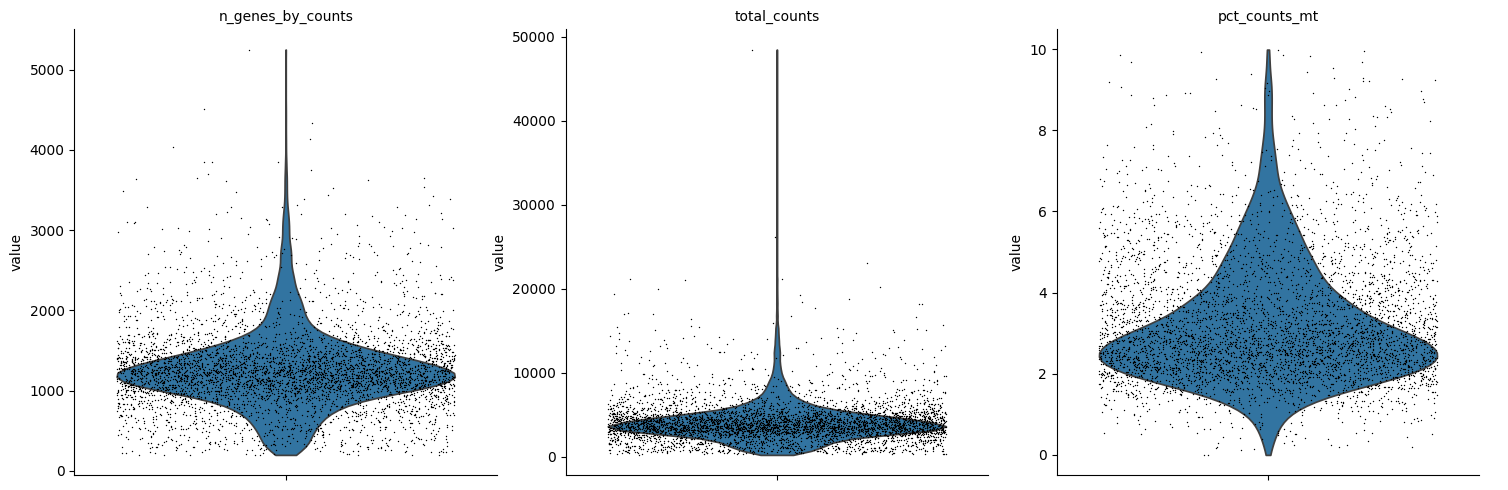

In [3]:
# =========================
# QC visualization
# =========================
sc.pl.violin(
    adata,
    ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
    jitter=0.4, multi_panel=True,
    stripplot=True, rotation=45
)
plt.show()

/tmp/ipython-input-267640698.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[0].legend()


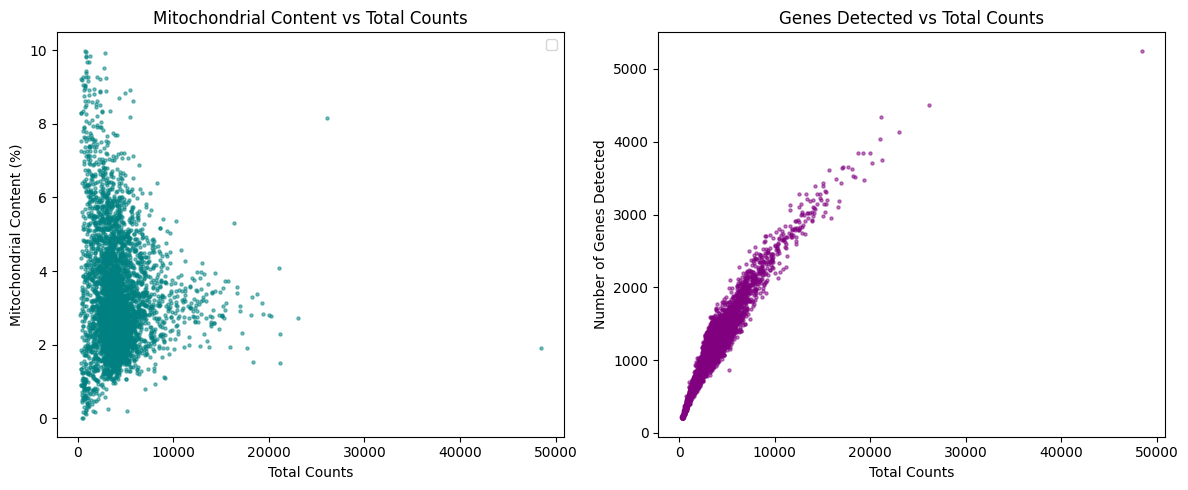

In [4]:
# Scatter plots to visualize relationships and spot residual outliers
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Mitochondrial content vs total counts
axs[0].scatter(adata.obs['total_counts'], adata.obs['pct_counts_mt'], s=5, alpha=0.5, color='teal')
axs[0].set_xlabel('Total Counts')
axs[0].set_ylabel('Mitochondrial Content (%)')
axs[0].set_title('Mitochondrial Content vs Total Counts')
axs[0].legend()

# Number of genes detected vs total counts
axs[1].scatter(adata.obs['total_counts'], adata.obs['n_genes_by_counts'], s=5, alpha=0.5, color='purple')
axs[1].set_xlabel('Total Counts')
axs[1].set_ylabel('Number of Genes Detected')
axs[1].set_title('Genes Detected vs Total Counts')

plt.tight_layout()
plt.show()

## 3. Normalization & Log Transform:
This step scales and stabilizes the data before feature selection and clustering. Without this, cells with more reads or extremely high gene counts could dominate the analysis.

In [5]:
# --- Normalize the data ---
# Normalize total counts per cell so that each cell has the same total count (target_sum = 10,000)
# This ensures comparability between cells by removing sequencing depth bias
sc.pp.normalize_total(adata, target_sum=1e4)

# --- Log-transform the data ---
# Apply log(x + 1) transformation to reduce the impact of highly expressed genes
# This makes the data more normally distributed and suitable for downstream analysis
sc.pp.log1p(adata)

## 4. Highly Variable Genes (HVGs) + Forced Markers
This cell picks the most informative genes for PBMCs and prepares them for downstream analysis. It first computes the top 2,000 highly variable genes (HVGs) using the Seurat method, then force-includes canonical immune markers (T, B, NK, monocytes, dendritic cells, platelets) so key biology isn’t dropped if a marker isn’t highly variable. Using this combined mask, it subsets the data to HVGs + markers, preserves a raw copy, and finally normalizes each cell to 10k counts and log-transforms the subset—yielding a compact, biologically grounded feature matrix ready for PCA/UMAP and clustering.

In [6]:
# --- Identify Highly Variable Genes (HVGs) ---
# Select the top 2,000 HVGs using the Seurat method.
# HVGs capture most of the biological signal useful for clustering.
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000, subset=False)

# --- Canonical PBMC markers to keep even if not in HVGs ---
# T cells:        CD3D, CD3E, IL7R
# B cells:        MS4A1, CD79A
# Monocytes:      CD14, LYZ
# NK cells:       GNLY, NKG7, GZMB
# FCGR3A mono:    FCGR3A
# Inflammatory:   S100A8, S100A9
# Dendritic:      FCER1A (pDC), CLEC9A, BATF3 (cDC1)
# Platelets:      PPBP
# Stromal/other:  CST3 (often ambient/stromal signal in PBMCs)
force_genes = [
    'CD3D','CD3E','IL7R','MS4A1','CD79A','CD14','LYZ',
    'FCGR3A','S100A8','S100A9','GNLY','NKG7','GZMB',
    'FCER1A','CST3','CLEC9A','BATF3','PPBP'
]

# --- Ensure markers are kept even if not in top HVGs ---
hvg_mask = adata.var['highly_variable'].copy()
for g in force_genes:
    if g in adata.var_names: # only if gene exists in this dataset
        hvg_mask[adata.var_names.get_loc(g)] = True # flip mask to keep it

# --- Subset to HVGs + forced markers and preserve a raw view ---
adata_hvg = adata[:, hvg_mask].copy()
adata_hvg.raw = adata[:, hvg_mask].copy() # store unnormalized counts for reference

# --- Re-normalize and log-transform after HVG selection ---
# Ensures the reduced dataset is scaled and ready for analysis
sc.pp.normalize_total(adata_hvg, target_sum=1e4)
sc.pp.log1p(adata_hvg)

/tmp/ipython-input-719653115.py:26: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  hvg_mask[adata.var_names.get_loc(g)] = True # flip mask to keep it


## 5. Dimensionality Reduction & Neighbors (PCA → kNN)
This cell builds the PBMC clustering graph and partitions it. It first runs PCA (50 PCs) on the HVG+marker matrix to denoise and compress the data, then constructs a k-nearest neighbors graph using the top 40 PCs with 10 neighbors per cell to capture local structure. Finally, it performs Leiden community detection (resolution = 0.5) on that graph, assigning each cell to a cluster stored in adata_hvg.obs['leiden'].

In [7]:
# --- Dimensionality reduction (PCA) ---
# Compute first 50 principal components on the HVG+markers matrix
sc.tl.pca(adata_hvg, n_comps=50)

# --- Graph construction (kNN on PCs) ---
# Build a k-nearest neighbors graph using the top 40 PCs and 10 neighbors per cell
# (these values control local connectivity used by graph-based clustering)
sc.pp.neighbors(adata_hvg, n_neighbors=10, n_pcs=40)

# --- Unsupervised clustering (Leiden) ---
# Partition the kNN graph into communities; 'resolution' controls cluster granularity
# Lower resolution -> fewer/larger clusters; higher -> more/smaller clusters
# Results will be stored in adata_hvg.obs['leiden']
sc.tl.leiden(adata_hvg, resolution=0.5, key_added='leiden')

/tmp/ipython-input-3992680664.py:14: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_hvg, resolution=0.5, key_added='leiden')


## 6. Unsupervised Clustering & Marker-Based Label Inference
This block assigns cell-type labels to Leiden clusters using simple marker panels. For each cluster, it computes the average expression of the marker genes for each candidate lineage (CD4 T, CD8 T, B cells, monocytes, NK, dendritic, platelets), skipping any markers not present in the data. The cell type with the highest mean marker signal is chosen for that cluster, and the result is written to adata_hvg.obs['cell_type']. It’s a quick, interpretable way to infer labels when no ground truth is provided.

In [8]:
# =========================
# Marker-based annotation
# =========================
# Define simple marker panels for major PBMC lineages.
# Each entry lists genes whose expression should be high in that cell type.
marker_panels = {
    'CD4_T':['CD3D','CD4'],
    'CD8_T':['CD3D','CD8A'],
    'B_cells':['MS4A1','CD79A'],
    'Mono':['CD14','LYZ'],
    'NK':['GNLY','NKG7'],
    'Dendritic':['FCER1A'],
    'Platelets':['PPBP']
}
cluster2type = {}
# Iterate over Leiden cluster categories
for clu in adata_hvg.obs['leiden'].cat.categories:
    # Boolean mask for cells in this cluster
    cells = adata_hvg.obs['leiden'] == clu
    means = {
        ct: adata_hvg[cells, [g for g in gs if g in adata_hvg.var_names]].X.mean()
        for ct, gs in marker_panels.items()
    }
    # Pick the cell type with the highest mean marker signal for this cluster
    cluster2type[clu] = max(means, key=means.get)

# Map cluster → inferred cell type back to per-cell annotations
adata_hvg.obs['cell_type'] = adata_hvg.obs['leiden'].map(cluster2type)

## 7. Cell Count
This prints a clean summary of how many cells belong to each annotated cell_type in the preprocessed HVG subset (adata_hvg).

In [9]:
# Display the count of cells for each annotated cell type
print("\n--- Annotated Cell Type Distribution ---")
print(adata_hvg.obs['cell_type'].value_counts().to_string())


--- Annotated Cell Type Distribution ---
cell_type
CD4_T        2466
Mono         1141
B_cells       652
NK            203
Dendritic     165
Platelets      34


## 8. Save Preprocessed Object

In [10]:
adata_hvg.write("processed_dataset/pbmc4k_preprocessed.h5ad")